In [1]:
import numpy as np
import matplotlib.pyplot as plt

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [22]:

class JetEngine:
    def __init__(self):
        # ratio of spec. heat
        self.y_air = 1.4
        # ratio of spec. heat
        self.y_exh = 1.4
        # gas constant for air. m2/s2/K
        self.R_air = 287
        # gas constant for the exhaust m2/s2/K
        self.R_exh = 287
        # heat capacity of air (J/K)
        self.cp_air = 1000.
        # heat capacity of the exhaust (J/K)
        self.cp_exh = 1000.
        # Fuel heating value, J/K
        self.Qr = 30 * 10**6
        
        # compressor P ratio
        self.CPR = 28
        # efficiency of the compressor
        self.eff_c = .959
        # burner temperature, K
        self.BTK = 2260
        # burner pressure ratio, slightly less then one
        self.BPR = 1.0
        # efficiency of the turbine
        self.eff_t = 0.982
        # efficiency of the nozzle
        self.eff_n = 0.92
        # Area of the exahust, m2
        self.A8 = np.pi * 0.5**2
        
    def update( self, altitude, speed ):
        # Altitude (m)
        h = altitude
        # Speed (m/s)
        ua = speed
        ##
        y_air = self.y_air
        y_exh = self.y_exh
        R_air = self.R_air
        R_exh = self.R_exh
        cp_air = self.cp_air
        cp_exh = self.cp_exh
        Qr = self.Qr
        # https://www.grc.nasa.gov/www/k-12/VirtualAero/BottleRocket/airplane/atmos.html
        h_f = h * 3.28084
        Ta_f = 59 - 0.00356 * h_f
        Pa_psf = 2116 * ( (Ta_f + 459.7) / 518.6)**5.256
        # Kelvin
        Ta = (Ta_f - 32)*(5/9) + 273.15
        # Pascal
        Pa = Pa_psf * 47.8803
        # speed of sound
        c_amb = np.sqrt( y_air * R_air * Ta )
        # Mach number = ua / c at ambient conditions
        M_amb = ua / c_amb
        T0 = Ta
        P0 = Pa
        # Intake
        T1 = T0 * ( 1 + (y_air-1)/2 * M_amb**2 )
        P1 = P0 * (T1/T0) ** (y_air/(y_air-1))
        # Before of the blade
        T2 = T1
        P2 = P1 * ( 1 - 0.075 * (M_amb-1)**1.35) if M_amb > 1 else P1
        # After Compressor
        P3 = P2 * self.CPR
        T3 = T2 / self.eff_c * ( (P3/P2)**((y_air-1)/y_air) )
        W  = cp_air * (T3-T2)
        # Burner
        T4 = self.BTK
        P4 = P3 * self.BPR
        # Turbine
        T5 = T4 - (T3-T2)
        P5 = ( (1 - 1/self.eff_t * (1-T5/T4))**(y_exh/(y_exh-1)) ) * P4
        # Nozzle
        T6 = T5
        P6 = P5
        T7 = T6
        P7 = P6
        P8 = P7
        T8 = T7 # / self.eff_n * ( (P8/P7)**((y_exh-1)/y_exh) )
        # exhaust speed
        u8 = np.sqrt( 2 * cp_exh * T5 * self.eff_n * (1-(Pa/P5)**((y_exh-1)/y_exh)) )
        # speed of sound in the exhaust
        c_exh = np.sqrt( y_exh * R_exh * T8 )
        M_exh = u8 / c_exh
        # mass coming out of the exhaust, limited by the chocking of the nozzle
        m = self.A8 * M_exh * P5 * np.sqrt(y_exh/R_exh/T8) * ( 1 + (y_exh-1)/2 * M_exh**2 ) ** (-0.5*(y_exh+1)/(y_exh-1))
        # gross trust
        F = m * u8
        # fuel fraction, uses convervation of energy
        # fuel @ T4 + air @ T4 = energy-from-fuel + air @ T3 ##### + fuel @ T_fuel
        f = (T4-T3) / (Qr/cp_exh - T4)
        # air ingested
        ma = m * (1-f)
        # fuel consumed
        mf = m * f
        # net thrust
        Fn = m * u8 - ma * ua
        # save stuff
        self.T = np.array([T0,T1,T2,T3,T4,T5,T6,T7,T8,T0])
        self.P = np.array([P0,P1,P2,P3,P4,P5,P6,P7,P8,P0])
        self.cp = np.array([cp_air,cp_air,cp_air,cp_air,cp_exh,cp_exh,cp_exh,cp_exh,cp_exh,cp_air])
        self.R  = np.array([R_air,R_air,R_air,R_air,R_exh,R_exh,R_exh,R_exh,R_exh,R_air])
        self.S = self.cp * np.log(self.T) - self.R * np.log(self.P)
        self.net_thrust = Fn
        self.fuel_flow = mf
        self.v_exh = u8
        

    def show(self):
        T = self.T
        P = self.P
        S = self.S
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
        ax1.set_ylabel('T (K)')
        ax1.plot(T[:-1])
        ax2.set_ylabel('P (atm)')
        ax2.plot(P[:-1] / 101325)
        ax3.set_ylabel('S (kJ/K)')
        ax3.plot(S[:-1] / 1000)
        _ = ax2.set_ylim(-0.1,)
        plt.show()
        
    def show_TS(self):        
        T = self.T
        P = self.P
        S = self.S
        fig, (ax4) = plt.subplots(1, 1)
        displ = np.array([[0,0],[10,0],[20,0],[0,0],[0,0],[0,0],[10,0],[20,0],[0,0],[30,0]])*4
        ax4.plot(S,T)
        ax4.plot(S,T,'.')
        ax4.set_xlabel('S (J/K)')
        ax4.set_ylabel('T (K)')
        for i,(ss,tt) in enumerate(zip(S[:-1],T[:-1])):
            label = "{:d}".format(i)
            ax4.annotate(label, (ss+displ[i,0],tt+displ[i,1]), textcoords="offset points", xytext=(10,0), ha='center')
        plt.show()
            

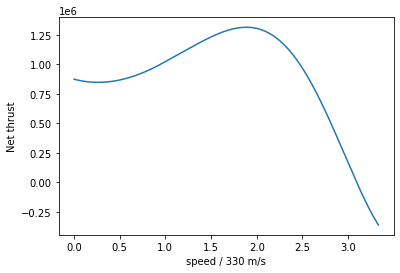

########## MACH ~ 1 #############


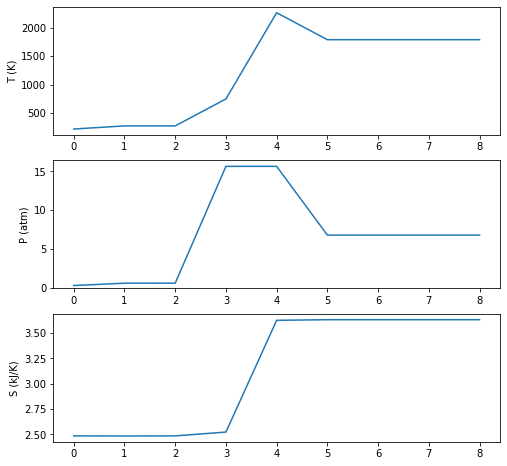

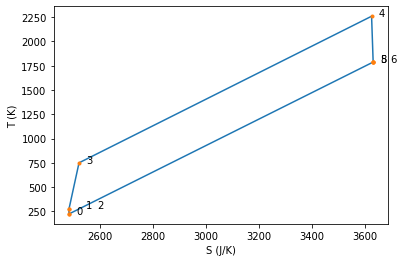

########## MACH ~ 2 #############


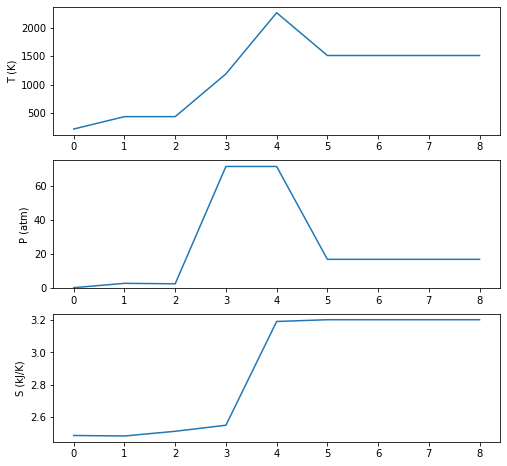

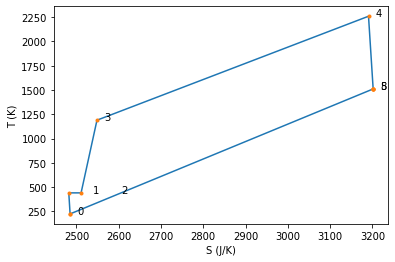

########## MACH ~ 3 #############


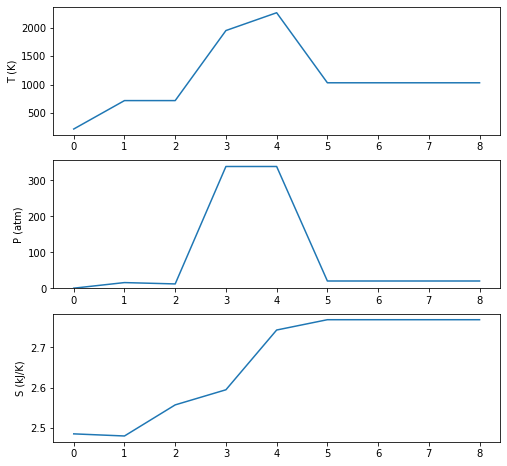

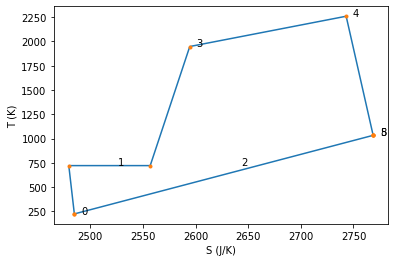

In [25]:
JE = JetEngine()

vv = []
FF = []
for v in range( 1, 1100 ):
    JE.update(1000, v)
    vv.append(v/330)
    FF.append(JE.net_thrust)
    
plt.plot(vv,FF)
plt.ylabel('Net thrust')
plt.xlabel('speed / 330 m/s')
plt.show()

print('########## MACH ~ 1 #############')
JE.update(10000, 330)
JE.show()
JE.show_TS()

print('########## MACH ~ 2 #############')
JE.update(10000, 660)
JE.show()
JE.show_TS()

print('########## MACH ~ 3 #############')
JE.update(10000, 1000)
JE.show()
JE.show_TS()

########## MACH 3+ #############


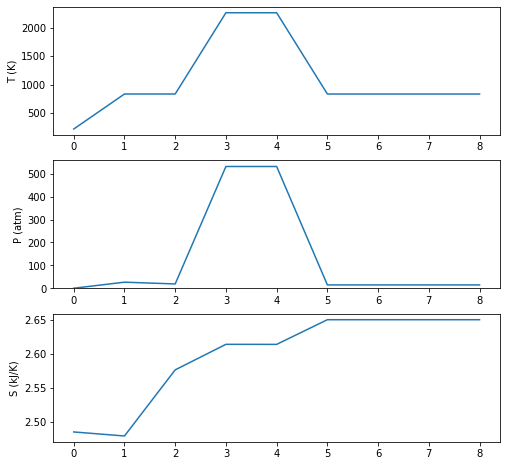

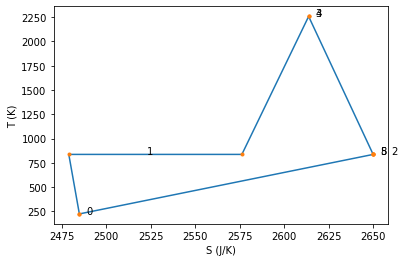

In [31]:
print('########## MACH 3+ #############')
JE.update(10000, 1110)
JE.show()
JE.show_TS()